In [8]:
import time

import arviz
import numpy as np
import pandas as pd
import pystan

In [4]:
# Parameters
P = 10
N = 10 ** 4
SEED = 1729

In [5]:
# Ground truth
np.random.seed(SEED)
true_transmission_rate = np.random.beta(2, 10, P)
true_occurrence_rate = np.random.beta(2, 10, P)
base_rate = np.random.beta(2, 10, 1)

In [6]:
# Simulate data
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], N)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission
data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)

z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
X = X.loc[:, X.columns.str.startswith('O')]
y = (z > 0).astype(int)

In [7]:
# Create model
sm = pystan.StanModel(model_name='tt_mod', model_code="""
data {
  int<lower=0> N;                            // number of observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
}
model {
  // Priors
  theta ~ uniform(0, 1);
  rho ~ uniform(0, 1);
  // Likelihood
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m(theta[p]);
      }
    }
    s += log1m(rho);
    if (y[n] == 1) {
      target += log1m_exp(s);
    } else {
      target += s;
    }
  }
}
""")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL tt_mod_d348a5d8586623ddc3995113fed4ea2b NOW.


In [9]:
# Set model parameters
nuts_samples = 20000
nuts_burnin = 10000
chains = 16

In [10]:
# Fit model
start = time.time()
model_data = {'N': N, 'P': P, 'X': X.to_numpy(), 'y': y.to_numpy()}
fit = sm.sampling(
    data=model_data,
    iter=nuts_samples,
    warmup=nuts_burnin,
    chains=16
)
print(f"{time.time() - start:.02f} seconds elapsed")

1197.39 seconds elapsed


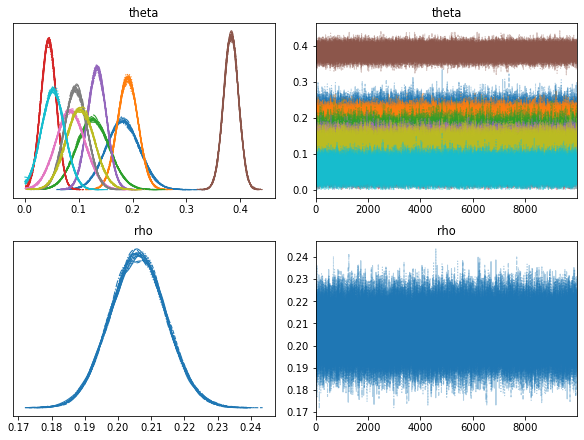

In [11]:
# Evaluate fit
arviz.plot_trace(fit, figsize=(8, 6));

In [12]:
# View results
print(fit)
print()
print(true_transmission_rate)
print(base_rate)

Inference for Stan model: tt_mod_d348a5d8586623ddc3995113fed4ea2b.
16 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=160000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    0.18  7.7e-5   0.03   0.12   0.16   0.18    0.2   0.24 161435    1.0
theta[2]    0.19  4.7e-5   0.02   0.15   0.18   0.19    0.2   0.23 165687    1.0
theta[3]    0.13  7.6e-5   0.03   0.07   0.11   0.13   0.15   0.19 158827    1.0
theta[4]    0.04  4.0e-5   0.01   0.02   0.03   0.04   0.05   0.07 124336    1.0
theta[5]    0.13  4.5e-5   0.02    0.1   0.12   0.13   0.15   0.17 153879    1.0
theta[6]    0.38  3.4e-5   0.01   0.36   0.37   0.38   0.39   0.41 166130    1.0
theta[7]    0.08  7.1e-5   0.03   0.03   0.07   0.08    0.1   0.14 144833    1.0
theta[8]    0.09  5.4e-5   0.02   0.05   0.08   0.09   0.11   0.14 149497    1.0
theta[9]     0.1  6.7e-5   0.03   0.05   0.08    0.1   0.12   0.15 152491    1.0